# Predicting the Number of Daily Trips

After performing an exploratory analysis on the bike sharing services in San Francisco and Seattle (https://github.com/Currie32/Bike-Sharing-in-SF-and-Seattle), I wanted to follow this up by building a predictive model. The goal for this report is to create a model that can accurately predict the number of trips taken, on a given day, with San Francisco's bike sharing service. I will only be using information that the bike sharing company could know at the start of the day, i.e. weather report, number of bikes availble, type of day (business day vs holiday vs weekend). 

### Load the Packages

In [1]:
import pandas as pd
import numpy as np
from scipy.stats.stats import pearsonr  
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from datetime import datetime
from sklearn.model_selection import train_test_split
import math
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import FeatureUnion
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error, median_absolute_error
import xgboost as xgb

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### Import the Data

In [2]:
df = pd.read_csv("../input/trip.csv")
weather = pd.read_csv("../input/weather.csv")
stations = pd.read_csv("../input/station.csv")

## Explore the Trips data frame

If you would like to see a comprehensive exploration of this data, please visit my other report: https://github.com/Currie32/Bike-Sharing-in-SF-and-Seattle

In [3]:
df.head()

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code
0,4576,63,8/29/2013 14:13,South Van Ness at Market,66,8/29/2013 14:14,South Van Ness at Market,66,520,Subscriber,94127
1,4607,70,8/29/2013 14:42,San Jose City Hall,10,8/29/2013 14:43,San Jose City Hall,10,661,Subscriber,95138
2,4130,71,8/29/2013 10:16,Mountain View City Hall,27,8/29/2013 10:17,Mountain View City Hall,27,48,Subscriber,97214
3,4251,77,8/29/2013 11:29,San Jose City Hall,10,8/29/2013 11:30,San Jose City Hall,10,26,Subscriber,95060
4,4299,83,8/29/2013 12:02,South Van Ness at Market,66,8/29/2013 12:04,Market at 10th,67,319,Subscriber,94103


In [4]:
df.isnull().sum()

id                       0
duration                 0
start_date               0
start_station_name       0
start_station_id         0
end_date                 0
end_station_name         0
end_station_id           0
bike_id                  0
subscription_type        0
zip_code              6619
dtype: int64

In [5]:
df.duration.describe()

count    6.699590e+05
mean     1.107950e+03
std      2.225544e+04
min      6.000000e+01
25%      3.440000e+02
50%      5.170000e+02
75%      7.550000e+02
max      1.727040e+07
Name: duration, dtype: float64

In [6]:
#Change duration from seconds to minutes
df.duration /= 60

In [7]:
df.duration.describe()

count    669959.000000
mean         18.465831
std         370.923950
min           1.000000
25%           5.733333
50%           8.616667
75%          12.583333
max      287840.000000
Name: duration, dtype: float64

In [8]:
#I want to remove major outliers from the data; trips longer than 6 hours. This will remove less than 0.5% of the data.
df['duration'].quantile(0.995)
df = df[df.duration <= 360]

In [9]:
df.shape

(666872, 11)

In [10]:
#Convert to datetime so that it can be manipulated more easily
df.start_date = pd.to_datetime(df.start_date, format='%m/%d/%Y %H:%M')

In [11]:
#Extract the year, month, and day from start_date
df['date'] = df.start_date.dt.date

In [12]:
#Each entry in the date feature is a trip. 
#By finding the total number of times a date is listed, we know how many trips were taken on that date.
dates = {}
for d in df.date:
    if d not in dates:
        dates[d] = 1
    else:
        dates[d] += 1

In [13]:
#Create the data frame that will be used for training, with the dictionary we just created.
df2 = pd.DataFrame.from_dict(dates, orient = "index")
df2['date'] = df2.index
df2['trips'] = df2.ix[:,0]
train = df2.ix[:,1:3]
train.reset_index(drop = True, inplace = True)

In [14]:
train

,date,trips
0,2013-08-29,742
1,2013-08-30,699
2,2013-08-31,628
3,2013-09-01,683
4,2013-09-02,652
5,2013-09-03,592
6,2013-09-04,599
7,2013-09-05,671
8,2013-09-06,810
9,2013-09-07,788


In [15]:
#All sorted now!
train = train.sort('date')
train.reset_index(drop=True, inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


## Explore the Weather data frame

In [16]:
weather.head()

,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code
0,8/29/2013,74.0,68.0,61.0,61.0,58.0,56.0,93.0,75.0,57.0,...,10.0,10.0,23.0,11.0,28.0,0,4.0,NaN,286.0,94107
1,8/30/2013,78.0,69.0,60.0,61.0,58.0,56.0,90.0,70.0,50.0,...,10.0,7.0,29.0,13.0,35.0,0,2.0,NaN,291.0,94107
2,8/31/2013,71.0,64.0,57.0,57.0,56.0,54.0,93.0,75.0,57.0,...,10.0,10.0,26.0,15.0,31.0,0,4.0,NaN,284.0,94107
3,9/1/2013,74.0,66.0,58.0,60.0,56.0,53.0,87.0,68.0,49.0,...,10.0,10.0,25.0,13.0,29.0,0,4.0,NaN,284.0,94107
4,9/2/2013,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,...,10.0,6.0,23.0,12.0,30.0,0,6.0,NaN,277.0,94107


In [17]:
weather.isnull().sum()

date                                 0
max_temperature_f                    4
mean_temperature_f                   4
min_temperature_f                    4
max_dew_point_f                     54
mean_dew_point_f                    54
min_dew_point_f                     54
max_humidity                        54
mean_humidity                       54
min_humidity                        54
max_sea_level_pressure_inches        1
mean_sea_level_pressure_inches       1
min_sea_level_pressure_inches        1
max_visibility_miles                13
mean_visibility_miles               13
min_visibility_miles                13
max_wind_Speed_mph                   1
mean_wind_speed_mph                  1
max_gust_speed_mph                 899
precipitation_inches                 1
cloud_cover                          1
events                            3143
wind_dir_degrees                     1
zip_code                             0
dtype: int64

In [18]:
weather.date = pd.to_datetime(weather.date, format='%m/%d/%Y')

In [19]:
#The weather data frame is 5 times as long as the train data frame, 
#therefore there are 5 entries per date.
print (train.shape)
print (weather.shape)

(733, 2)
(3665, 24)


In [20]:
#It seems we have one entry per zip code
weather.zip_code.unique()

array([94107, 94063, 94301, 94041, 95113])

In [21]:
#Let's see which zip code has the cleanest date.
for zc in weather.zip_code.unique():
    print (weather[weather.zip_code == zc].isnull().sum())
    print ()

date                                0
max_temperature_f                   0
mean_temperature_f                  0
min_temperature_f                   0
max_dew_point_f                     0
mean_dew_point_f                    0
min_dew_point_f                     0
max_humidity                        0
mean_humidity                       0
min_humidity                        0
max_sea_level_pressure_inches       0
mean_sea_level_pressure_inches      0
min_sea_level_pressure_inches       0
max_visibility_miles                0
mean_visibility_miles               0
min_visibility_miles                0
max_wind_Speed_mph                  0
mean_wind_speed_mph                 0
max_gust_speed_mph                 13
precipitation_inches                0
cloud_cover                         0
events                            574
wind_dir_degrees                    0
zip_code                            0
dtype: int64

date                                0
max_temperature_f                   

In [22]:
#I used this zip code for my other report as well. It is missing only a bit of data and is formatted rather well.
weather = weather[weather.zip_code == 94107]

In [23]:
weather.events.unique()

array([nan, 'Fog', 'Rain', 'Fog-Rain', 'rain', 'Rain-Thunderstorm'], dtype=object)

In [24]:
weather.loc[weather.events == 'rain', 'events'] = "Rain"
weather.loc[weather.events.isnull(), 'events'] = "Normal"

In [25]:
weather.events

0                  Normal
1                  Normal
2                  Normal
3                  Normal
4                  Normal
5                  Normal
6                  Normal
7                  Normal
8                  Normal
9                  Normal
10                 Normal
11                 Normal
12                 Normal
13                 Normal
14                    Fog
15                 Normal
16                 Normal
17                 Normal
18                 Normal
19                 Normal
20                 Normal
21                 Normal
22                 Normal
23                   Rain
24                 Normal
25                 Normal
26                 Normal
27                 Normal
28                 Normal
29                 Normal
              ...        
2175               Normal
2176               Normal
2177               Normal
2178               Normal
2179    Rain-Thunderstorm
2180               Normal
2181               Normal
2182        

In [26]:
events = pd.get_dummies(weather.events)

In [27]:
weather = weather.merge(events, left_index = True, right_index = True)

In [28]:
#Remove features we don't need
weather = weather.drop(['events','zip_code'],1)

In [29]:
#max_wind and max_gust are well correlated, so we can use max_wind to help fill the null values of max_gust
print (pearsonr(weather.max_wind_Speed_mph[weather.max_gust_speed_mph >= 0], 
               weather.max_gust_speed_mph[weather.max_gust_speed_mph >= 0]))

(0.78884768322591059, 6.0272032072715235e-154)


In [30]:
#For each value of max_wind, find the median max_gust and use that to fill the null values.
weather.loc[weather.max_gust_speed_mph.isnull(), 'max_gust_speed_mph'] = weather.groupby('max_wind_Speed_mph').max_gust_speed_mph.apply(lambda x: x.fillna(x.median()))

In [31]:
weather.isnull().sum()

date                              0
max_temperature_f                 0
mean_temperature_f                0
min_temperature_f                 0
max_dew_point_f                   0
mean_dew_point_f                  0
min_dew_point_f                   0
max_humidity                      0
mean_humidity                     0
min_humidity                      0
max_sea_level_pressure_inches     0
mean_sea_level_pressure_inches    0
min_sea_level_pressure_inches     0
max_visibility_miles              0
mean_visibility_miles             0
min_visibility_miles              0
max_wind_Speed_mph                0
mean_wind_speed_mph               0
max_gust_speed_mph                0
precipitation_inches              0
cloud_cover                       0
wind_dir_degrees                  0
Fog                               0
Fog-Rain                          0
Normal                            0
Rain                              0
Rain-Thunderstorm                 0
dtype: int64

In [32]:
#Change this feature from a string to numeric.
#Use errors = 'coerce' because some values currently equal 'T' and we want them to become NAs.
weather.precipitation_inches = pd.to_numeric(weather.precipitation_inches, errors = 'coerce')

In [33]:
#Change null values to the median, of values > 0, because T, I think, means True. 
#Therefore we want to find the median amount of precipitation on days when it rained.
weather.loc[weather.precipitation_inches.isnull(), 
            'precipitation_inches'] = weather[weather.precipitation_inches.notnull()].precipitation_inches.median()

In [34]:
train = train.merge(weather, on = train.date)

In [35]:
#Need to remove the extra date columns, otherwise good!
train.head()

,date_x,trips,date_y,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,...,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,wind_dir_degrees,Fog,Fog-Rain,Normal,Rain,Rain-Thunderstorm
0,2013-08-29,742,2013-08-29,74.0,68.0,61.0,61.0,58.0,56.0,93.0,...,11.0,28.0,0.0,4.0,286.0,0,0,1,0,0
1,2013-08-30,699,2013-08-30,78.0,69.0,60.0,61.0,58.0,56.0,90.0,...,13.0,35.0,0.0,2.0,291.0,0,0,1,0,0
2,2013-08-31,628,2013-08-31,71.0,64.0,57.0,57.0,56.0,54.0,93.0,...,15.0,31.0,0.0,4.0,284.0,0,0,1,0,0
3,2013-09-01,683,2013-09-01,74.0,66.0,58.0,60.0,56.0,53.0,87.0,...,13.0,29.0,0.0,4.0,284.0,0,0,1,0,0
4,2013-09-02,652,2013-09-02,75.0,69.0,62.0,61.0,60.0,58.0,93.0,...,12.0,30.0,0.0,6.0,277.0,0,0,1,0,0


In [36]:
train['date'] = train['date_x']
train.drop(['date_y','date_x'],1, inplace= True)

## Explore the Stations data frame

In [37]:
stations.head()

,id,name,lat,long,dock_count,city,installation_date
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013


In [38]:
#Good, each stations is only listed once
print (len(stations.name.unique()))
print (stations.shape)

70
(70, 7)


In [39]:
stations.installation_date = pd.to_datetime(stations.installation_date, format = "%m/%d/%Y").dt.date

In [40]:
#The min date is before any in the train data frame, therefore stations were installed before the first trips (good).
#The max date is before the end of the train data frame, therefore the service has not been adding new stations recently.
print (stations.installation_date.min())
print (stations.installation_date.max())

2013-08-05
2014-04-09


In [41]:
#For each day in train.date, find the number of docks (parking spots for individual bikes) that were installed 
#on or before that day.
total_docks = []
for day in train.date:
    total_docks.append(sum(stations[stations.installation_date <= day].dock_count))

In [42]:
train['total_docks'] = total_docks

## Add Special Date Features

In [43]:
#Find all of the holidays during our time span
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays(start=train.date.min(), end=train.date.max())

In [44]:
holidays

DatetimeIndex(['2013-09-02', '2013-10-14', '2013-11-11', '2013-11-28',
               '2013-12-25', '2014-01-01', '2014-01-20', '2014-02-17',
               '2014-05-26', '2014-07-04', '2014-09-01', '2014-10-13',
               '2014-11-11', '2014-11-27', '2014-12-25', '2015-01-01',
               '2015-01-19', '2015-02-16', '2015-05-25', '2015-07-03'],
              dtype='datetime64[ns]', freq=None)

In [45]:
#Find all of the business days in our time span
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
business_days = pd.DatetimeIndex(start=train.date.min(), end=train.date.max(), freq=us_bd)

In [46]:
business_days

DatetimeIndex(['2013-08-29', '2013-08-30', '2013-09-03', '2013-09-04',
               '2013-09-05', '2013-09-06', '2013-09-09', '2013-09-10',
               '2013-09-11', '2013-09-12',
               ...
               '2015-08-18', '2015-08-19', '2015-08-20', '2015-08-21',
               '2015-08-24', '2015-08-25', '2015-08-26', '2015-08-27',
               '2015-08-28', '2015-08-31'],
              dtype='datetime64[ns]', length=503, freq='C')

In [47]:
business_days = pd.to_datetime(business_days, format='%Y/%m/%d').date
holidays = pd.to_datetime(holidays, format='%Y/%m/%d').date

In [48]:
#A 'business_day' or 'holiday' is a date within either of the respected lists.
train['business_day'] = train.date.isin(business_days)
train['holiday'] = train.date.isin(holidays)

In [49]:
train.head()

,trips,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,wind_dir_degrees,Fog,Fog-Rain,Normal,Rain,Rain-Thunderstorm,date,total_docks,business_day,holiday
0,742,74.0,68.0,61.0,61.0,58.0,56.0,93.0,75.0,57.0,...,286.0,0,0,1,0,0,2013-08-29,1150,True,False
1,699,78.0,69.0,60.0,61.0,58.0,56.0,90.0,70.0,50.0,...,291.0,0,0,1,0,0,2013-08-30,1150,True,False
2,628,71.0,64.0,57.0,57.0,56.0,54.0,93.0,75.0,57.0,...,284.0,0,0,1,0,0,2013-08-31,1150,False,False
3,683,74.0,66.0,58.0,60.0,56.0,53.0,87.0,68.0,49.0,...,284.0,0,0,1,0,0,2013-09-01,1150,False,False
4,652,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,...,277.0,0,0,1,0,0,2013-09-02,1150,False,True


In [50]:
#Convert True to 1 and False to 0
train.business_day = train.business_day.map(lambda x: 1 if x == True else 0)
train.holiday = train.holiday.map(lambda x: 1 if x == True else 0)

In [51]:
#Convert date to the important features, year, month, weekday (0 = Monday, 1 = Tuesday...)
#We don't need day because what it represents changes every year.
train['year'] = pd.to_datetime(train['date']).dt.year
train['month'] = pd.to_datetime(train['date']).dt.month
train['weekday'] = pd.to_datetime(train['date']).dt.weekday

In [52]:
labels = train.trips
train = train.drop(['trips', 'date'], 1)

## Train the Model

In [53]:
X_train, X_test, y_train, y_test = train_test_split(train, labels, test_size=0.2, random_state = 2)

In [54]:
#15 fold cross validation. Multiply by -1 to make values positive.
#Used median absolute error to learn how many trips my predictions are off by.

def scoring(clf):
    scores = cross_val_score(clf, X_train, y_train, cv=15, n_jobs=1, scoring = 'neg_median_absolute_error')
    print (np.median(scores) * -1)

In [55]:
rfr = RandomForestRegressor(n_estimators = 55,
                            min_samples_leaf = 3,
                            random_state = 2)
scoring(rfr)

54.723997114


In [56]:
gbr = GradientBoostingRegressor(learning_rate = 0.12,
                                n_estimators = 150,
                                max_depth = 8,
                                min_samples_leaf = 1,
                                random_state = 2)
scoring(gbr)

52.6821685348


In [57]:
dtr = DecisionTreeRegressor(min_samples_leaf = 3,
                            max_depth = 8,
                            random_state = 2)
scoring(dtr)

59.6


In [58]:
abr = AdaBoostRegressor(n_estimators = 100,
                        learning_rate = 0.1,
                        loss = 'linear',
                        random_state = 2)
scoring(abr)

89.6285714286


In [59]:
import warnings
warnings.filterwarnings("ignore")

random_state = 2
params = {
        'eta': 0.15,
        'max_depth': 6,
        'min_child_weight': 2,
        'subsample': 1,
        'colsample_bytree': 1,
        'verbose_eval': True,
        'seed': random_state,
    }

n_folds = 15 #number of Kfolds
cv_scores = [] #The sum of the mean_absolute_error for each fold.
early_stopping_rounds = 100
iterations = 10000
printN = 50
fpred = [] #stores the sums of predicted values for each fold.

testFinal = xgb.DMatrix(X_test)

kf = KFold(len(X_train), n_folds=n_folds)

for i, (train_index, test_index) in enumerate(kf):
    print('\n Fold %d' % (i+1))
    Xtrain, Xval = X_train.iloc[train_index], X_train.iloc[test_index]
    Ytrain, Yval = y_train.iloc[train_index], y_train.iloc[test_index]
    
    xgtrain = xgb.DMatrix(Xtrain, label = Ytrain)
    xgtest = xgb.DMatrix(Xval, label = Yval)
    watchlist = [(xgtrain, 'train'), (xgtest, 'eval')] 
    
    xgbModel = xgb.train(params, 
                         xgtrain, 
                         iterations, 
                         watchlist,
                         verbose_eval = printN,
                         early_stopping_rounds=early_stopping_rounds
                        )
    
    scores_val = xgbModel.predict(xgtest, ntree_limit=xgbModel.best_ntree_limit)
    cv_score = median_absolute_error(Yval, scores_val)
    print('eval-MSE: %.6f' % cv_score)
    y_pred = xgbModel.predict(testFinal, ntree_limit=xgbModel.best_ntree_limit)
    print(xgbModel.best_ntree_limit)

    if i > 0:
        fpred = pred + y_pred #sum predictions
    else:
        fpred = y_pred
    pred = fpred
    cv_scores.append(cv_score)

xgb_preds = pred / n_folds #find the average values for the predictions
score = np.median(cv_scores)
print('Median error: %.6f' % score)


 Fold 1
[0]	train-rmse:859.779	eval-rmse:860.909
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[50]	train-rmse:20.7369	eval-rmse:113.332
[100]	train-rmse:7.9436	eval-rmse:114.767
Stopping. Best iteration:
[38]	train-rmse:26.8545	eval-rmse:111.666

eval-MSE: 55.529480
39

 Fold 2
[0]	train-rmse:860.98	eval-rmse:832.034
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[50]	train-rmse:19.8007	eval-rmse:174.169
[100]	train-rmse:6.12341	eval-rmse:173.62
[150]	train-rmse:2.492	eval-rmse:174.024
Stopping. Best iteration:
[72]	train-rmse:11.4503	eval-rmse:173.246

eval-MSE: 47.253143
73

 Fold 3
[0]	train-rmse:860.443	eval-rmse:842.757
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[50]	train-rmse:23.2613	ev

In [60]:
#Train and make predictions with the best models.
rfr = rfr.fit(X_train, y_train)
gbr = gbr.fit(X_train, y_train)

rfr_preds = rfr.predict(X_test)
gbr_preds = gbr.predict(X_test)

#Weight the top models to find the best prediction
final_preds = rfr_preds*0.32 + gbr_preds*0.38 + xgb_preds*0.3
print ("Daily error of trip count:", median_absolute_error(y_test, final_preds))

Daily error of trip count: 46.7571098802


In [61]:
#A reminder of the range of values in number of daily trips.
labels.describe()

count     733.000000
mean      909.784447
std       403.863930
min        81.000000
25%       445.000000
50%      1041.000000
75%      1264.000000
max      1509.000000
Name: trips, dtype: float64

In [62]:
y_test.reset_index(drop = True, inplace = True)

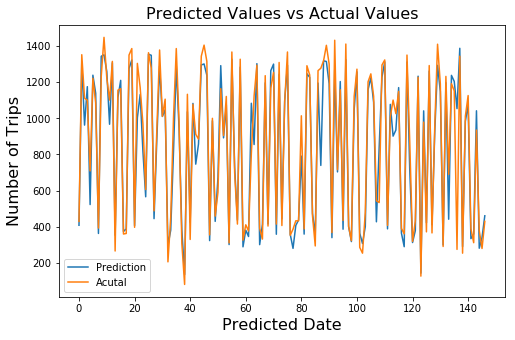

In [63]:
fs = 16
plt.figure(figsize=(8,5))
plt.plot(final_preds)
plt.plot(y_test)
plt.legend(['Prediction', 'Acutal'])
plt.ylabel("Number of Trips", fontsize = fs)
plt.xlabel("Predicted Date", fontsize = fs)
plt.title("Predicted Values vs Actual Values", fontsize = fs)
plt.show()

In [64]:
#Create a plot that ranks the features by importance.
def plot_importances(model, model_name):
    importances = model.feature_importances_
    std = np.std([model.feature_importances_ for feature in model.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]    

    # Plot the feature importances of the forest
    plt.figure(figsize = (8,5))
    plt.title("Feature importances of " + model_name)
    plt.bar(range(X_train.shape[1]), importances[indices], color="r", align="center")
    plt.xticks(range(X_train.shape[1]), indices)
    plt.xlim([-1, X_train.shape[1]])
    plt.show()

Feature ranking:
0 max_temperature_f
1 mean_temperature_f
2 min_temperature_f
3 max_dew_point_f
4 mean_dew_point_f
5 min_dew_point_f
6 max_humidity
7 mean_humidity
8 min_humidity
9 max_sea_level_pressure_inches
10 mean_sea_level_pressure_inches
11 min_sea_level_pressure_inches
12 max_visibility_miles
13 mean_visibility_miles
14 min_visibility_miles
15 max_wind_Speed_mph
16 mean_wind_speed_mph
17 max_gust_speed_mph
18 precipitation_inches
19 cloud_cover
20 wind_dir_degrees
21 Fog
22 Fog-Rain
23 Normal
24 Rain
25 Rain-Thunderstorm
26 total_docks
27 business_day
28 holiday
29 year
30 month
31 weekday


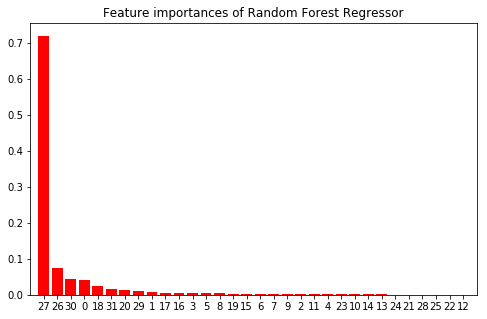

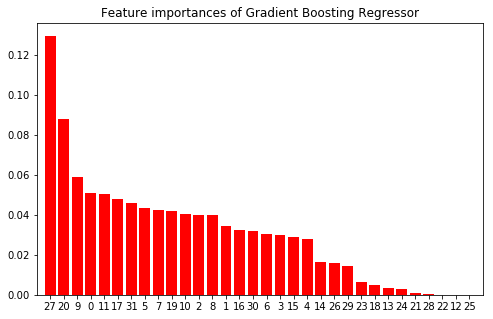

In [65]:
# Print the feature ranking
print("Feature ranking:")

i = 0
for feature in X_train:
    print (i, feature)
    i += 1
    
plot_importances(rfr, "Random Forest Regressor")
plot_importances(gbr, "Gradient Boosting Regressor")

The feature importance ranking for the random forest regressor makes more sense to me than for the gradient boosting regressor. Features, such as 'business_day', 'total_docks', and 'month' match better with my exploratory analysis than 'wind_dir_degrees' and 'max_sea_level_pressure_inches.' Although I have not looked at the data yet, perhaps wind from a particular direction correlates with worse weather/cycling conditions.

## Summary

I believe that I have made a good model to predict how many trips will occur with San Francisco's bike sharing service. My model has a median absolute error of almost 47 trips per day. This should give the company operating this service a good, general estimate of the traffic that will occur each day. 

I like how my model can provide a good estimate while only using information that is available to the company at the start of the day, i.e. weather forecast, type of day (business day, holiday, etc), and number of bikes that are available. There are a number of ways to make this model, or a similar model, more practical/useful, including: predicting the number of daily trips to/from each station, using the number of trips in the morning to predict the number of trips in the afternoon, and predicting when a station will run out of bikes.